# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

Жесткий дедлайн: 26.11.2023

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 11

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import make_scorer

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn.dummy import DummyClassifier

from sklearn import svm

import warnings
warnings.filterwarnings("ignore")

from sklearn.svm import SVC

from sklearn.calibration import CalibratedClassifierCV

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

from sklearn.model_selection import KFold

from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

import time

import statistics


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [ ]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: y_random возвращает вероятность каждого исхода (используем функцию predict_proba), а не класс.

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [ ]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import make_scorer

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

Random Classifier metrics
AUC-PR: 0.74650
AUC-ROC: 0.50000


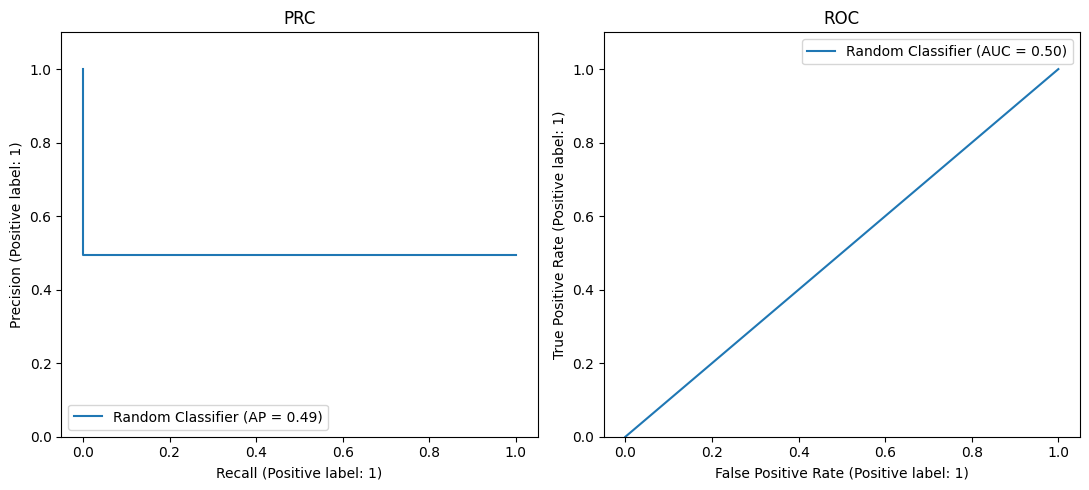

In [ ]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [ ]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.7465,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

param_grid = {'C': np.logspace(-2, 3, 20)}

svc_cv = GridSearchCV(estimator=LinearSVC(max_iter=100000), param_grid=param_grid, cv=5, scoring='average_precision')
svc_cv.fit(X_val, y_val)

best_svc = svc_cv.best_estimator_
svc_pred_lin = best_svc.decision_function(X_test)
print('Best C:', svc_cv.best_params_['C'])
print('SVC AUC-PR:', average_precision_score(y_test, svc_pred_lin))

Best C: 297.63514416313194
SVC AUC-PR: 0.8362368787105733


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

Classifier with regularization metrics
AUC-PR: 0.83608
AUC-ROC: 0.84116


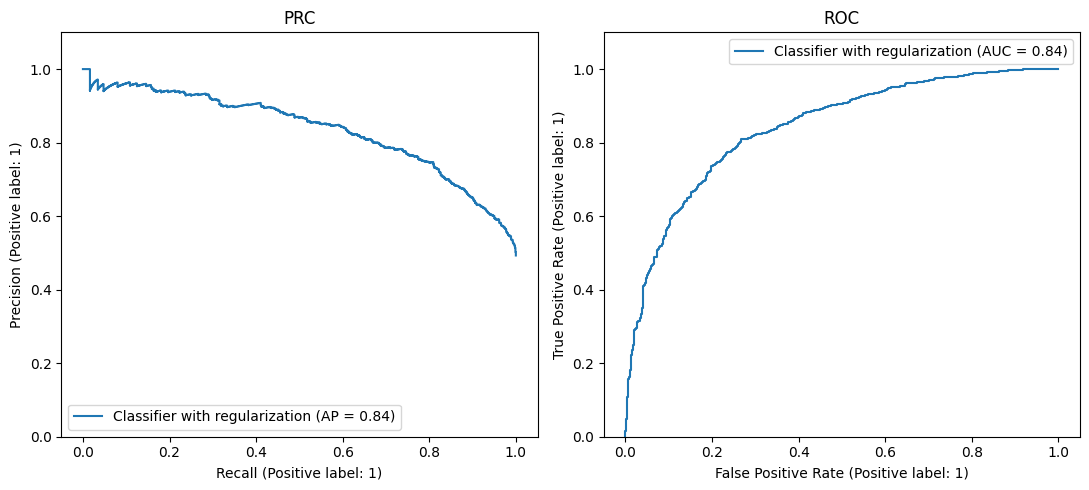

In [ ]:
depict_pr_roc(y_test, svc_pred_lin, 'Classifier with regularization')

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

И AUC-ROC, и AUC-PR выросли значительно, что логично.

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
param_grid = {'C': np.logspace(-2, 3, 20)}

svc_cv = GridSearchCV(estimator=LogisticRegression(max_iter=100000), param_grid=param_grid, cv=5, scoring='average_precision')
svc_cv.fit(X_val, y_val)

best_svc = svc_cv.best_estimator_
svc_pred_log = best_svc.decision_function(X_test)
print('Best C:', svc_cv.best_params_['C'])

Best C: 0.01


Classifier with regularization metrics
AUC-PR: 0.83430
AUC-ROC: 0.84060


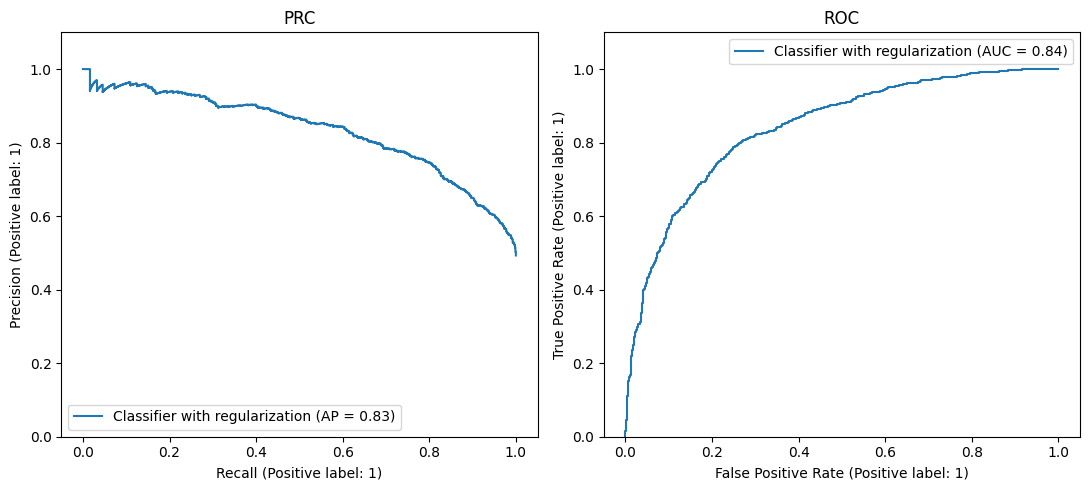

In [ ]:
depict_pr_roc(y_test, svc_pred_log, 'Classifier with regularization')

По сравнению со случайны классификатором, и AUC-ROC, и AUC-PR выросли значительно, что логично.

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

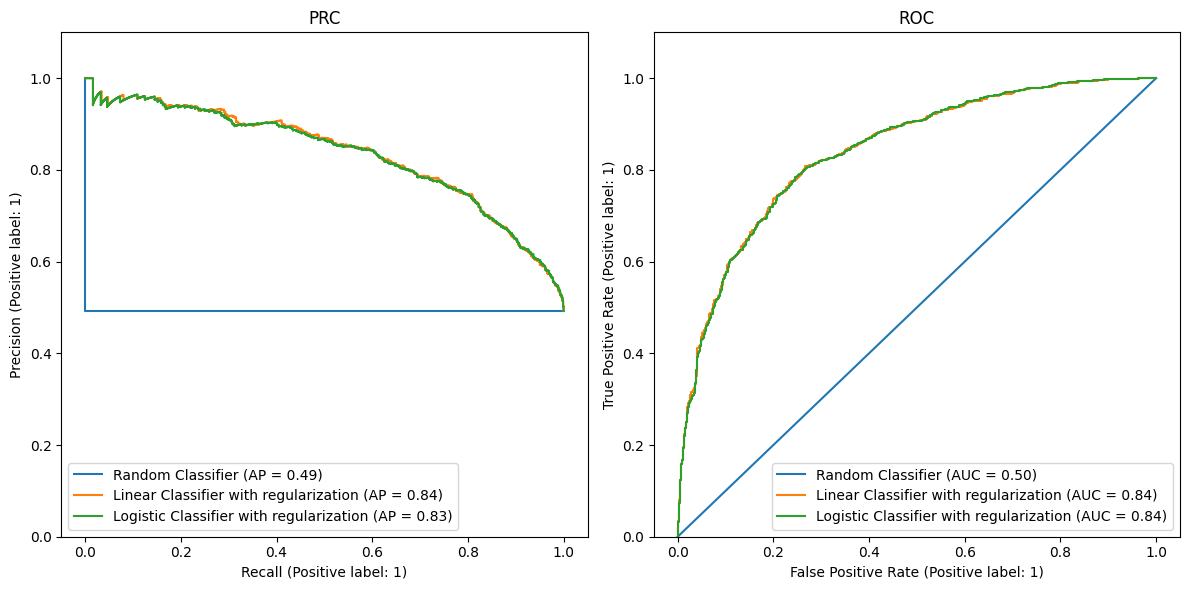

In [ ]:
def depict_pr_roc(y_true, y_pred, classifier_name, ax_prc, ax_roc):
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax_prc, name=classifier_name)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    ax_prc.set_title("PRC")
    ax_prc.set_ylim(0, 1.1)
    ax_prc.legend()

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax_roc, name=classifier_name)
    ax_roc.set_title("ROC")
    ax_roc.set_ylim(0, 1.1)
    ax_roc.legend()
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
depict_pr_roc(y_test, y_random, 'Random Classifier', axes[0], axes[1])
depict_pr_roc(y_test, svc_pred_lin, 'Linear Classifier with regularization', axes[0], axes[1])
depict_pr_roc(y_test, svc_pred_log, 'Logistic Classifier with regularization', axes[0], axes[1])
plt.tight_layout()
plt.show()


**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** Как видно из графиков и из количественных метрик, результаты для AUC-ROC и AUC-PR практически не отличаются. Тем не менее от случайного классификатора они отличаются значительно - больше, чем в полтора раза. В случае со случайной классификацией модель не различает положительный и отрицательный класс, поэтому она одинаково правильно и неправильно угадала TP и TN, из-за чего AUC ROC приблизительно равно 0.5. Чем больше этот показатель, тем лучше, так что при SVM и логреге качество лучше, т.к. мы не просто берем рандомные числа. Площадь под PR кривой для случайного классификатора может быть больше 0.5, если у нас есть дисбаланс классов. Аналогично, в двух новых моделях результаты лучше, но между собой они практически не отличаются.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [ ]:
from sklearn import svm

Создаем синтетические данные.

In [ ]:
X, y = make_classification(n_samples = 1000, n_features = 2, n_informative = 2, n_redundant = 0, random_state = 42)

Задаем модель.

In [ ]:
clf = svm.SVC(kernel='linear', C = 1.0)

In [ ]:
model = clf.fit(X,y)

Представленный в задании код странно рисует разделяющую прямую, я его поправила немного.

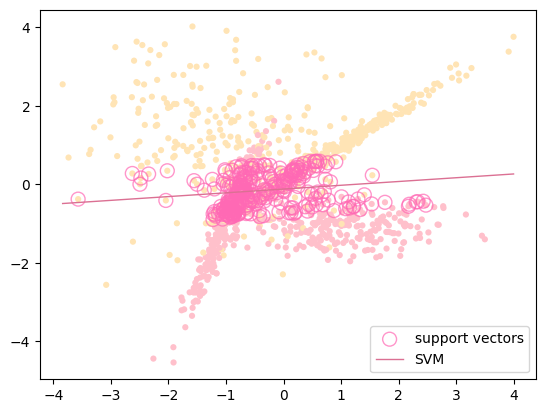

In [ ]:
def plot_svm_2D(X, y, model, plot_support=True):
    # Создали сетку
    xx = np.linspace(X[:, 0].min(), X[:, 0].max(), 30)
    yy = np.linspace(X[:, 1].min(), X[:, 1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.predict(np.c_[XX.ravel(), YY.ravel()])
    Z = Z.reshape(XX.shape)

    custom_cmap = plt.cm.colors.ListedColormap(['pink', 'moccasin'])

    # Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=custom_cmap, s=20, edgecolors='none')

    support_indices = np.where(np.abs(model.decision_function(X)) <= 1)[0]
    support_vectors = X[support_indices]

    # Отрисовали опорные векторы
    if plot_support:
        plt.scatter(support_vectors[:, 0],
                    support_vectors[:, 1],
                    label = 'support vectors',
                    s=100,
                    linewidth=1,
                    edgecolor = "hotpink",
                    facecolors='none',
                    alpha=0.7)
    w = model.coef_[0]
    plt.plot(xx, - w[0] / w[1] * xx - model.intercept_[0] / w[1], "palevioletred", linewidth = 1, label = "SVM")
    plt.legend()

plot_svm_2D(X, y, model)



Вот, что выходило изначально.

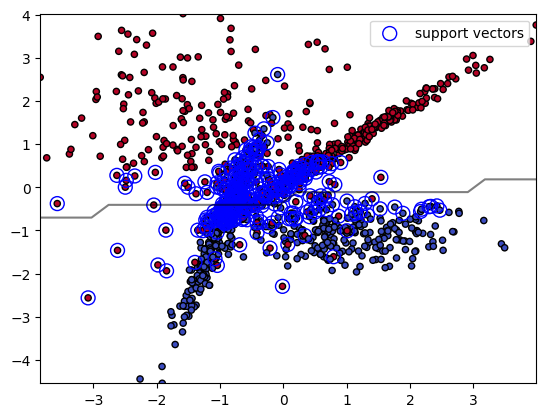

In [ ]:
def plot_svm_2D(X, y, model,  plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки разделяющей прямой
    Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])
    Z = Z.reshape(XX.shape)
    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

    support_vectors = clf.support_vectors_
    #Отрисовали опорные векторы
    if plot_support:
        plt.scatter(support_vectors[:, 0],
                    support_vectors[:, 1],
                    label='support vectors',
                    s=100,
                    linewidth=1,
                    edgecolor="blue",
                    facecolors='none')

    plt.legend()

plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** Как опорные выделяются те, что в розовых кружках на моем графике (или в синих на втором).

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [ ]:
clflog = LogisticRegression(random_state=42).fit(X, y)

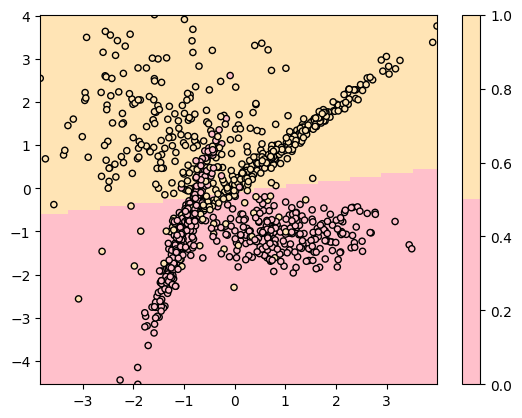

In [ ]:
def plot_logreg_2D(X, y, model):
    # Создали сетку
    xx = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    yy = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки распределения
    Z = model.predict(np.c_[XX.ravel(), YY.ravel()])
    Z = Z.reshape((xx.shape[0], -1)).T
    custom_cmap = plt.cm.colors.ListedColormap(['pink', 'moccasin'])

    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=custom_cmap)


    # Use the 'Paired' colormap for coloring data points based on class labels
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=custom_cmap, s=20, edgecolors='k')

    plt.colorbar(image)

plot_logreg_2D(X, y, clflog)


**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** Она визуализированая линией перехода из одного цвета в другой. Теоретически это можно обосновать тем, что логистическая регрессия выдает вероятность положительного класса. $p(y=+1∣x)= 1/(1 + e ^{-z})$. Когда z = 0 (то есть $w_0 + w_1 * x_1... =0$), вероятность будет равна 0.5, и модель не будет точно знать, к какому классу отнести объект, он будет находиться на разделяющей прямой.


#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [369]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = (1.0 / n_bins) * i
        r = (1.0 / n_bins) * (i + 1)
        bin_middle_points.append((l + r) / 2) # l + r вместо l - r
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) # mean вместо min
    plt.figure(figsize=(6,6))
    plt.grid(True)
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.plot(bin_middle_points, bin_middle_points)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [384]:
X, y = make_classification(n_samples = 10000, n_features = 2, n_informative = 2, n_redundant = 0, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [385]:
clflog = LogisticRegression(random_state = 42, max_iter=10000, C=0.1)
clflog.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=10000, random_state=42)

In [386]:
y_log_pred = clflog.predict_proba(X_test)[:, 1]

Калибровочная кривая для логистической регрессии.



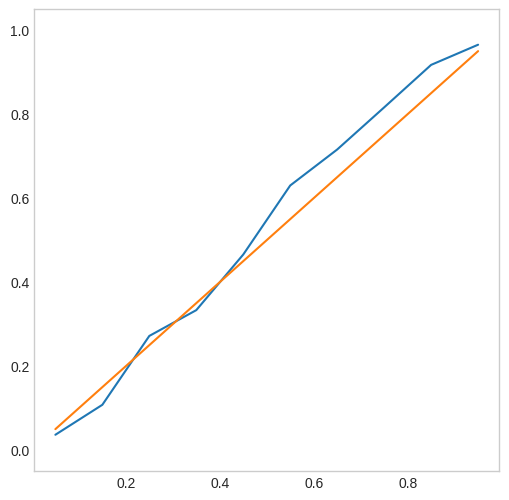

In [387]:
plot_calibration_curve(y_test, y_log_pred)

In [388]:
from sklearn.svm import SVC

In [389]:
clfsvm = SVC(kernel='linear', random_state = 42)

In [390]:
clfsvm.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [391]:
y_svm_pred = clfsvm.decision_function(X_test)

In [219]:
from numpy import exp

In [392]:
y_svm_pred = 1 / (1 + exp(- y_svm_pred))

Калибровочная кривая для SVM.

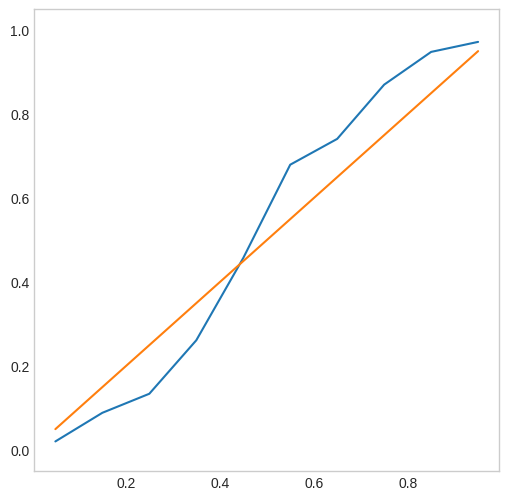

In [264]:
plot_calibration_curve(y_test, y_svm_pred)

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:**  В целом -да. График для SVM больше напоминает сигмоиду.

In [ ]:
y_log_pred = clflog.decision_function(X_test)
y_log_pred = 1 / (1 + exp(- y_log_pred))

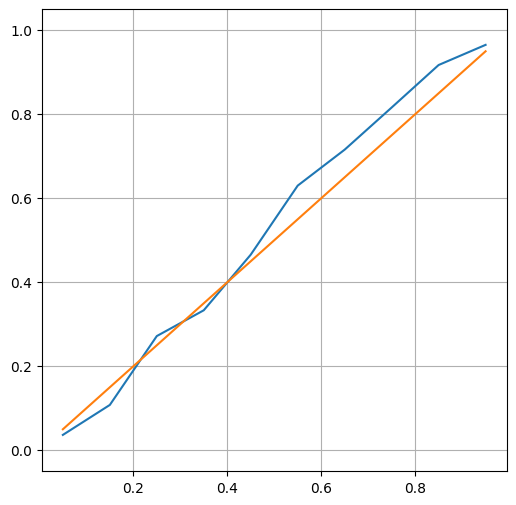

In [ ]:
plot_calibration_curve(y_test, y_log_pred)

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

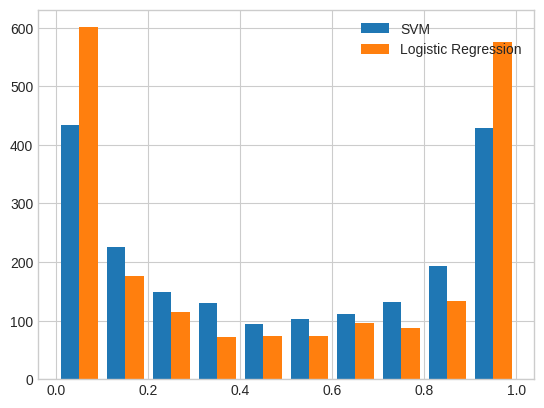

In [253]:
plt.hist([y_svm_pred, y_log_pred], label=['SVM', 'Logistic Regression'])
plt.legend(loc='upper right')
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** Графики распределения довольно похожи друг на друга. При этом кажется, что логичстическая регрессия более уверена в своих ответах, чем SVM. А похожи они потому, что предсказывают decision function.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [238]:
from sklearn.calibration import CalibratedClassifierCV

In [239]:
svcclf = SVC(kernel = 'linear', C = 0.1)

In [240]:
calibrated_clf = CalibratedClassifierCV(base_estimator = svcclf)

In [242]:
calibrated_clf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SVC(C=0.1, kernel='linear'))

In [245]:
y_svc_pred_calibrated = calibrated_clf.predict_proba(X_test)[:, 1]

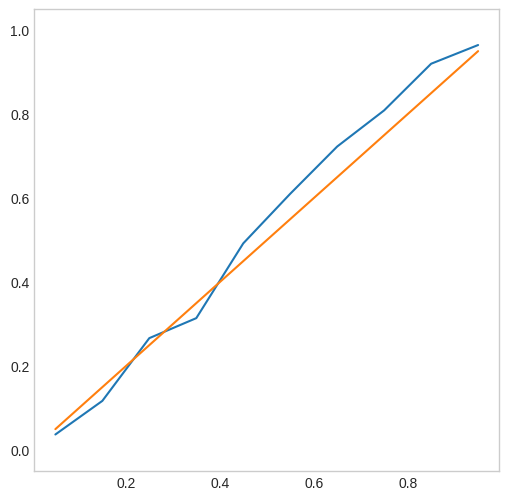

In [246]:
plot_calibration_curve(y_test, y_svc_pred_calibrated)

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** Да, расстояние между ней и диагональю уменьшилось.

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

Здесь я буду использовать библиотеку Scipy, которую мы проходили на курсе аналитики.

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [289]:
df = pd.read_csv('bike_buyers.csv')

In [ ]:
df.head(3)

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No


In [290]:
categorical = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']
numeric = ['Children', 'Cars', 'Age', 'Income']

In [291]:
df[categorical] = df[categorical].fillna('undefined')

In [292]:
X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

X_numerical = df[numeric]
X_categorical = df[categorical]

В начале поработаем только с категориальными признаками

In [293]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [276]:
from sklearn.preprocessing import OrdinalEncoder

In [277]:
import time

In [278]:
enc = OrdinalEncoder()

In [279]:
start= time.time()
X_train_enc = enc.fit_transform(X_train)
X_test_enc = enc.transform(X_test)
logclf = LogisticRegression()
logclf.fit(X_train_enc, y_train)
end= time.time()
print(f"AUC-PR: {average_precision_score(y_test, logclf.predict_proba(X_test_enc)[:, 1])}")
print(f"Это заняло {end - start} секунд")

AUC-PR: 0.5883009320176316
Это заняло 0.01471710205078125 секунд


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [280]:
from sklearn.preprocessing import OneHotEncoder

In [281]:
enc = OneHotEncoder()

In [282]:
start= time.time()
X_train_enc = enc.fit_transform(X_train)
X_test_enc = enc.transform(X_test)
logclf = LogisticRegression()
logclf.fit(X_train_enc, y_train)
end= time.time()
print(f"AUC-PR: {average_precision_score(y_test, logclf.predict_proba(X_test_enc)[:, 1])}")
print(f"Это заняло {end - start} секунд")

AUC-PR: 0.666642757355176
Это заняло 0.02977776527404785 секунд


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [283]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

In [ ]:
class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, encode_cols=None, target_col=None):
        if encode_cols is None:
            encode_cols = []
        if target_col is None:
            target_col = []
        self.target_col = target_col
        self.encode_cols = encode_cols

    def fit(self, X, y=None):
        self.mean_encodings = {}
        X['target'] = self.target_col
        for col in self.encode_cols:
            unique_values = X[col].unique()
            self.mean_encodings[col] = {}
            for val in unique_values:
                if col not in self.mean_encodings:
                    self.mean_encodings[col] = {}
                self.mean_encodings[col][val] = X[X[col] == val]['target'].mean()
        return self

    def transform(self, X, y=None):
        for col in self.encode_cols:
            X[col] = X[col].map(self.mean_encodings[col])
        return X

In [ ]:
start = time.time()
mean_target_encoder = MeanTargetEncoder(encode_cols= categorical, target_col=y)
mean_target_encoder.fit(X_categorical, y)
transformed_df = mean_target_encoder.transform(X_train)
logclf = LogisticRegression()
logclf.fit(transformed_df, y_train)
transformed_test = mean_target_encoder.transform(X_test)
end= time.time()
print(f"AUC-PR: {average_precision_score(y_test, logclf.predict_proba(transformed_test)[:, 1])}")
print(f"Это заняло {end - start} секунд")

AUC-PR: 0.705534920302603
Это заняло 0.05438637733459473 секунд


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [ ]:
# Выполнено выше

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [294]:
class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, encode_cols=None, target_col=None, noise_level=0):
        if encode_cols is None:
            encode_cols = []
        if target_col is None:
            target_col = []
        self.target_col = target_col
        self.encode_cols = encode_cols
        self.noise_level = noise_level

    def fit(self, X, y=None):
        self.mean_encodings = {}
        X['target'] = self.target_col
        for col in self.encode_cols:
            unique_values = X[col].unique()
            self.mean_encodings[col] = {}
            for val in unique_values:
                if col not in self.mean_encodings:
                    self.mean_encodings[col] = {}
                self.mean_encodings[col][val] = X[X[col] == val]['target'].mean()
        return self

    def transform(self, X, y=None):
        for col in self.encode_cols:
            random_noise = np.random.normal(0, self.noise_level, size=X.shape[0])
            X[col] = X[col].map(self.mean_encodings[col]) + random_noise
        return X


In [304]:
X_numerical = df[numeric]
X_categorical = df[categorical]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

In [305]:
start = time.time()
mean_target_encoder = MeanTargetEncoder(encode_cols= categorical, target_col=y, noise_level = 0.05 * (1 - np.random.random()))
mean_target_encoder.fit(X_categorical, y)
transformed_df = mean_target_encoder.transform(X_train)
logclf = LogisticRegression()
logclf.fit(transformed_df, y_train)
transformed_test = mean_target_encoder.transform(X_test)
end= time.time()
print(f"AUC-PR: {average_precision_score(y_test, logclf.predict_proba(transformed_test)[:, 1])}")
print(f"Это заняло {end - start} секунд")

AUC-PR: 0.7063685462744098
Это заняло 0.07711958885192871 секунд


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Если добавить шум совсем маленький, то качество улучшится. Если же побольше, то ухудшится.

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [ ]:
#your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [318]:
class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, encode_cols=None, target_col=None, noise_level=0, C=10):
        if encode_cols is None:
            encode_cols = []
        if target_col is None:
            target_col = []
        self.target_col = target_col
        self.encode_cols = encode_cols
        self.noise_level = noise_level
        self.C = C

    def fit(self, X, y=None):
        self.mean_encodings = {}
        X['target'] = self.target_col
        global_mean = X['target'].mean()
        for col in self.encode_cols:
            unique_values = X[col].unique()
            self.mean_encodings[col] = {}
            for val in unique_values:
                category_mean = X[X[col] == val]['target'].mean()
                sample_size = X[X[col] == val].shape[0]
                self.mean_encodings[col][val] = (category_mean * sample_size + global_mean * self.C) / (sample_size + self.C)
        return self

    def transform(self, X, y=None):
        for col in self.encode_cols:
            random_noise = np.random.normal(0, self.noise_level, size=X.shape[0])
            X[col] = X[col].map(self.mean_encodings[col]) + random_noise
        return X

In [322]:
X_numerical = df[numeric]
X_categorical = df[categorical]
df[categorical] = df[categorical].fillna('undefined')
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

In [323]:
start = time.time()
mean_target_encoder = MeanTargetEncoder(encode_cols= categorical, target_col=y, noise_level = 0.05 * (1 - np.random.random()))
mean_target_encoder.fit(X_categorical, y)
X_train_transformed = mean_target_encoder.transform(X_train)
X_val_transformed = mean_target_encoder.transform(X_val)

param_grid = {'C': np.logspace(-2, 3, 5)}

log_cv = GridSearchCV(estimator=LogisticRegression(max_iter=100000), param_grid=param_grid, cv=5, scoring='average_precision')
log_cv.fit(X_val_transformed, y_val)

logclf = LogisticRegression(C = log_cv.best_params_['C'])
logclf.fit(X_train_transformed, y_train)
transformed_test = mean_target_encoder.transform(X_test)
end= time.time()
print(f"AUC-PR: {average_precision_score(y_test, logclf.predict_proba(transformed_test)[:, 1])}")
print(f"Это заняло {end - start} секунд")

AUC-PR: 0.6899119742256432
Это заняло 0.30000829696655273 секунд


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [343]:
X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')
df[categorical] = df[categorical].fillna('undefined')
X_numerical = df[numeric]
X_categorical = df[categorical]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

In [344]:
from sklearn.impute import SimpleImputer

In [345]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(X_numerical)

X_numerical = imputer.transform(X_numerical)

In [346]:
mean_target_encoder = MeanTargetEncoder(encode_cols= categorical, target_col=y, noise_level = 30)
mean_target_encoder.fit(X_categorical, y)

MeanTargetEncoder(encode_cols=['Marital Status', 'Gender', 'Education',
                               'Occupation', 'Home Owner', 'Commute Distance',
                               'Region'],
                  noise_level=30,
                  target_col=0      0
1      0
2      0
3      1
4      1
      ..
995    1
996    1
997    1
998    0
999    1
Name: Purchased Bike, Length: 1000, dtype: int64)

In [347]:
X_categorical = mean_target_encoder.transform(X_categorical)

In [348]:
X_numerical = pd.DataFrame(X_numerical, columns=numeric)

In [349]:
transformed_df = (X_categorical).join(X_numerical)

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

In [350]:
transformed_df[numeric].nunique()

Children     7
Cars         6
Age         54
Income      17
dtype: int64

In [351]:
start = time.time()
mean_target_encoder = MeanTargetEncoder(encode_cols= numeric, target_col=y, noise_level = 30)
mean_target_encoder.fit(transformed_df, y)
transformed_df = mean_target_encoder.transform(transformed_df)

X_train, X_test, y_train, y_test = train_test_split(transformed_df, y, test_size=0.25, random_state=777, stratify=y)

logclf = LogisticRegression()
logclf.fit(X_train, y_train)
end= time.time()
print(f"AUC-PR: {average_precision_score(y_test, logclf.predict_proba(X_test)[:, 1])}")
print(f"Это заняло {end - start} секунд")

AUC-PR: 0.9999999999999999
Это заняло 0.13732194900512695 секунд


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ One-hot-кодирование выполнять быстрее, чем считать счетчики, но, тем не менее при ванхоте создается очень много признаков, что не очень хорошо. Еще счетчики более интуитивно понятны. При счетчиках может возникнуть утечка целевой перемнной, это нужно всегда иметь в виду. Еще auc pr при счетчиках получилась в среднем больше.

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [353]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2023-11-22 20:19:55--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data.12’

adult.data.12           [     <=>            ]   3.79M  3.09MB/s    in 1.2s    

2023-11-22 20:19:57 (3.09 MB/s) - ‘adult.data.12’ saved [3974305]



In [354]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
27315,27,Private,288229,Bachelors,13,Never-married,Adm-clerical,Own-child,Asian-Pac-Islander,Female,0,0,50,Laos,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [355]:
X = df.drop(columns=['income'])
y = (df['income'] == 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [356]:
categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
numeric = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

In [173]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaler', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer)
])

model = pipeline.fit(X, y)

print("New features after OneHotEncoding:", int(column_transformer.transform(X_train).shape[1]) - len(numeric))

lr = LogisticRegression(max_iter=100000, C=0.1).fit(column_transformer.transform(X_train), y_train)
lr_pred = lr.decision_function(column_transformer.transform(X_test))
print('Logistic regression ROC-PR:', average_precision_score(y_test, lr_pred))

New features after OneHotEncoding: 102
Logistic regression ROC-PR: 0.7676464223089904


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [46]:
transformed_data = column_transformer.transform(X).toarray()
ohe_columns = column_transformer.named_transformers_['ohe'].get_feature_names_out(categorical)
new_column_names = np.concatenate((ohe_columns, numeric))
transformed_df = pd.DataFrame(transformed_data, columns=new_column_names)

X_train, X_test, y_train, y_test = train_test_split(transformed_df, y, test_size=0.25, random_state=777, stratify=y)

ohe_feature_names = column_transformer.get_feature_names_out()
weights = lr.coef_

d = {}
for i, feature_name in enumerate(new_column_names):
    d[feature_name] = weights[0][i]

top_40_features = [key for key in sorted(d, key=lambda k: abs(d[k]))][-40:]

lr = LogisticRegression(max_iter=100000, C=0.1).fit(X_train[top_40_features], y_train)
lr_pred = lr.decision_function(X_test[top_40_features])
print('Logistic regression ROC-PR:', average_precision_score(y_test, lr_pred))

Logistic regression ROC-PR: 0.765239422161895


Изменилось ли качество? Как?

Незначительно, но ухудшилось(

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [ ]:
X = df.drop(columns=['income'])
y = (df['income'] == 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

In [ ]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('passthrough', 'passthrough', numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_include_numeric', column_transformer)
])

model = pipeline.fit(X, y)

lr = LogisticRegression(max_iter=100000, C=0.1).fit(column_transformer.transform(X_train), y_train)
lr_pred = lr.decision_function(column_transformer.transform(X_test))
print('Logistic regression ROC-PR:', average_precision_score(y_test, lr_pred))


Logistic regression ROC-PR: 0.45042464661807385


In [ ]:
transformed_data = column_transformer.transform(X).toarray()
ohe_columns = column_transformer.named_transformers_['ohe'].get_feature_names_out(categorical)
new_column_names = np.concatenate((ohe_columns, numeric))
transformed_df = pd.DataFrame(transformed_data, columns=new_column_names)

X_train, X_test, y_train, y_test = train_test_split(transformed_df, y, test_size=0.25, random_state=777, stratify=y)

ohe_feature_names = column_transformer.get_feature_names_out()
weights = lr.coef_

d = {}
for i, feature_name in enumerate(new_column_names):
    d[feature_name] = weights[0][i]

top_40_features_ = [key for key in sorted(d, key=lambda k: abs(d[k]))][-40:]

lr = LogisticRegression(max_iter=100000, C=0.1).fit(X_train[top_40_features_], y_train)
lr_pred = lr.decision_function(X_test[top_40_features_])
print('Logistic regression ROC-PR:', average_precision_score(y_test, lr_pred))

Logistic regression ROC-PR: 0.7596192075887748


Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [ ]:
X = transformed_df
y = (df['income'] == 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(transformed_df, y, test_size=0.25, random_state=777, stratify=y)

In [ ]:
column_transformer = ColumnTransformer([
    ('scaler', StandardScaler(), list(X))
])

pipeline = Pipeline(steps=[
    ('ohe_and_include_numeric', column_transformer)
])

model = pipeline.fit(X, y)

lr = LogisticRegression(max_iter=100000, C=0.1).fit(column_transformer.transform(X_train), y_train)
lr_pred = lr.decision_function(column_transformer.transform(X_test))
print('Logistic regression ROC-PR:', average_precision_score(y_test, lr_pred))

Logistic regression ROC-PR: 0.7661032869534067


In [ ]:
transformed_data = column_transformer.transform(X)
columns = column_transformer.get_feature_names_out()
new_column_names = columns
transformed_df = pd.DataFrame(transformed_data, columns=new_column_names)

X_train, X_test, y_train, y_test = train_test_split(transformed_df, y, test_size=0.25, random_state=777, stratify=y)

ohe_feature_names = column_transformer.get_feature_names_out()
weights = lr.coef_

d = {}
for i, feature_name in enumerate(new_column_names):
    d[feature_name] = weights[0][i]

top_40_features = [key for key in sorted(d, key=lambda k: abs(d[k]))][-40:]

lr = LogisticRegression(max_iter=100000, C=0.1).fit(X_train[top_40_features], y_train)
lr_pred = lr.decision_function(X_test[top_40_features])
print('Logistic regression ROC-PR:', average_precision_score(y_test, lr_pred))

Logistic regression ROC-PR: 0.7631788266154892


In [ ]:
from collections import Counter

In [ ]:
Counter(top_40_features) == Counter(top_40_features_)

False

Признаки поменялись.

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [40]:
from scipy.stats import ttest_ind

In [56]:
start = time.time()
X_1, X_0 = transformed_df[y == 1], transformed_df[y == 0]
n_1, n_0 = X_1.shape[0], X_0.shape[0]
s_1, s_0 = X_1.var(axis=0, ddof=1), X_0.var(axis=0, ddof=1)
t_statistics = abs(X_1.mean(axis=0)-X_0.mean(axis=0)) / np.sqrt((n_1 * s_1 + n_0 * s_0) / (n_1 + n_0))
top_40_features = np.argsort(t_statistics)[-40:]
end = time.time()
print(f"Это заняло {end - start}")

Это заняло 0.14344024658203125


In [66]:
top_40_features = top_40_features.index.tolist()

In [67]:
lr = LogisticRegression(max_iter=100000, C=0.1).fit(X_train[top_40_features], y_train)
lr_pred = lr.decision_function(X_test[top_40_features])
print('Logistic regression ROC-PR:', average_precision_score(y_test, lr_pred))

Logistic regression ROC-PR: 0.6496804752918264


#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [357]:
X = df.drop(columns=['income'])
y = (df['income'] == 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

In [358]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaler', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer)
])

model = pipeline.fit(X_train, y_train)

In [359]:
transformed_data = column_transformer.transform(X).toarray()
ohe_columns = column_transformer.named_transformers_['ohe'].get_feature_names_out(categorical)
new_column_names = np.concatenate((ohe_columns, numeric))
transformed_df = pd.DataFrame(transformed_data, columns=new_column_names)

In [360]:
X_train, X_test, y_train, y_test = train_test_split(transformed_df, y, test_size=0.25, random_state=777, stratify=y)

In [361]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=777, stratify=y_train)

In [53]:
lr = LogisticRegression(max_iter=1000, C=0.1).fit(X_train, y_train)

In [362]:
new_column_names = list(new_column_names)

In [87]:
start= time.time()
while (len(lr.coef_[0]) != 40):
  d = {}
  for feature_name in new_column_names:
    lr = LogisticRegression(max_iter=1000, C=0.1).fit(X_train.drop(feature_name, axis=1), y_train)
    y_pred = lr.decision_function(X_val.drop(feature_name, axis=1))
    d[feature_name] = average_precision_score(y_val, y_pred)
  X_train = X_train.drop(max(d, key=d.get), axis=1)
  X_val = X_val.drop(max(d, key=d.get), axis=1)
  new_column_names.remove(max(d, key=d.get))
end= time.time()

In [88]:
print(f"Это дело заняло {(end-start)/60} минут.")

Это дело заняло 29.78615484237671 минут.


In [89]:
lr = LogisticRegression(max_iter=100000, C=0.1).fit(X_train, y_train)
lr_pred = lr.decision_function(X_test[list(X_val)])
print('Logistic regression ROC-PR:', average_precision_score(y_test, lr_pred))

Logistic regression ROC-PR: 0.7648118888360876


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [363]:
X_train, X_test, y_train, y_test = train_test_split(transformed_df, y, test_size=0.25, random_state=777, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=777, stratify=y_train)

In [364]:
new_column_names = list(np.concatenate((ohe_columns, numeric)))

In [365]:
start= time.time()
top_40_features = []
best_auc = -np.inf
while (len(top_40_features) != 40):
  d = {}
  for feature_name in new_column_names:
    feature_now = list(top_40_features)
    feature_now.append(feature_name)
    lr = LogisticRegression(max_iter=1000, C=0.1).fit(X_train[feature_now], y_train)
    y_pred = lr.decision_function(X_val[feature_now])
    d[feature_name] = average_precision_score(y_val, y_pred)
  top_40_features.append(max(d, key=d.get))
  new_column_names.remove(max(d, key=d.get))
end= time.time()

In [366]:
print(f"Это дело заняло {(end-start)} секунд.")

Это дело заняло 426.82194209098816 секунд.


In [367]:
lr = LogisticRegression(max_iter=100000, C=0.1).fit(X_train, y_train)
lr_pred = lr.decision_function(X_test[list(X_val)])
print('Logistic regression ROC-PR:', average_precision_score(y_test, lr_pred))

Logistic regression ROC-PR: 0.766834128040722


Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:**

Отбор по наибольшему модулю: Logistic regression ROC-PR: 0.765239422161895 (ЛУЧШИЙ РЕЗУЛЬТАТ, один из самых быстрых методов, интуитивно понятный, но оправдан только при скейлинге)

OHE + Numeric scaling: 0.7676464223089904 (качество лучше, тоже не очень долгий)

OHE + Passthrough: 0.7596192075887748 (нелогичный, качество хуже, лучше так не делать, тк у признаков свой масштаб)

OHE + Scaling OHE: 0.7631788266154892 (качество хуже, чем просто при скейлинге количественных, но незначительно, в целом не очень оправдан)

T-stat: 0.6496804752918264 (качество значительно хуже, чем везде, не очобо долгий, лучше не использовать)

Wrapper removing: 0.7648118888360876 (логичный, неплохое качество, но ужасно медленный)

Wrapper adding: 0.766834128040722 (И ЭТО ВТОРОЙ ЛУЧШИЙ РЕЗУЛЬТАТ! при этом он не занял много времени, тк обучаем меньше моделей, чем при удалении)

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [91]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip

--2023-11-22 17:17:13--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip.9’

bank-additional.zip     [   <=>              ] 434.15K   572KB/s    in 0.8s    

2023-11-22 17:17:14 (572 KB/s) - ‘bank-additional.zip.9’ saved [444572]

Archive:  bank-additional.zip
replace bank-additional/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [138]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

In [93]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [139]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

In [123]:
categorical = [
    'job',
    'marital',
    'education',
    'default',
    'housing',
    'loan',
    'contact',
    'month',
    'day_of_week',
    'poutcome',
]

numeric = [
 'age',
 'campaign',
 'pdays',
 'previous']


In [140]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaler', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer)
])

model = pipeline.fit(X)

In [141]:
transformed_data = pipeline.transform(X).toarray()

In [142]:
ohe_columns = column_transformer.named_transformers_['ohe'].get_feature_names_out(categorical)
new_column_names = np.concatenate((ohe_columns, numeric))
transformed_data = pd.DataFrame(transformed_data, columns=new_column_names)

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [143]:
X_train, X_test, y_train, y_test = train_test_split(transformed_data, y, test_size = 0.25, random_state = 500)

In [144]:
cv = KFold(n_splits = 5, shuffle = True, random_state = 500)

In [145]:
train_dfs = {}
test_dfs = {}
y_train_dfs = {}
y_test_dfs = {}
for fold, (train_index, test_index) in enumerate(cv.split(transformed_data)):
    X_train, X_test = transformed_data.iloc[train_index], transformed_data.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    train_dfs[fold] = X_train
    y_train_dfs[fold] = y_train
    test_dfs[fold] = X_test
    y_test_dfs[fold] = y_test

In [128]:
X_train, X_test, y_train, y_test = train_test_split(transformed_data, y, test_size = 0.25, random_state = 500)

In [129]:
clf = LogisticRegressionCV(cv = cv).fit(X_train, y_train)

In [106]:
y_proba = clf.predict_proba(X_test)[:, 1]

In [107]:
print('AUC-PR:', average_precision_score(y_test, y_proba))

AUC-PR: 0.397043308350171


Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [108]:
revenues = []
costs = []
profits = []
calls_nums = []
for i in range(5):
  y_proba = clf.predict_proba(test_dfs[i])[:, 1]
  positive_predictions = y_proba >= 0.5
  true_positives = (positive_predictions & (y_test_dfs[i] == 1)).sum()
  total_calls = positive_predictions.sum()
  total_revenue = true_positives * 10
  total_cost = total_calls * 1
  profit = total_revenue - total_cost
  revenues.append(total_revenue)
  calls_nums.append(total_calls)
  costs.append(total_cost)
  profits.append(profit)

In [109]:
print(f'Стандартное отклонение выручки {statistics.stdev(revenues)}')
print(f'Средняя выручка {statistics.mean(revenues)}')
print(f'В среднем заплатим операторам {statistics.mean(costs)}')
print(f'Средняя прибыль {statistics.mean(profits)}')

Стандартное отклонение выручки 100.74720839804942
Средняя выручка 1740
В среднем заплатим операторам 258
Средняя прибыль 1482


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [110]:
revenues = []
costs = []
profits = []
calls_nums = []

for i in range(5):
    y_proba = clf.predict_proba(test_dfs[i])[:, 1]
    positive_predictions = y_proba >= 0.5
    true_positives = (positive_predictions & (y_test_dfs[i] == 1)).sum()
    total_calls = positive_predictions.sum()
    total_revenue = np.random.uniform(0, 20, true_positives).sum()
    total_cost = total_calls * 1
    profit = total_revenue - total_cost
    revenues.append(total_revenue)
    calls_nums.append(total_calls)
    costs.append(total_cost)
    profits.append(profit)

In [111]:
print(f'Стандартное отклонение выручки {statistics.stdev(revenues)}')
print(f'Средняя выручка {statistics.mean(revenues)}')
print(f'В среднем заплатим операторам {statistics.mean(costs)}')
print(f'Средняя прибыль {statistics.mean(profits)}')

Стандартное отклонение выручки 144.87304296443807
Средняя выручка 1746.5798073731805
В среднем заплатим операторам 258
Средняя прибыль 1488.5798073731805


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

Будем делать это руками, потому что в гридсерч очень сложно отправить такую сложную функциюю.

In [112]:
C_values = np.logspace(-4, 4, 20)
best_C = None
best_average_profit = -np.inf
profs_reg = []
errs_reg = []
for C in C_values:
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    profits = []
    for i in range(5):
        y_proba = model.predict_proba(test_dfs[i])[:, 1]
        positive_predictions = y_proba >= 0.5
        true_positives = (positive_predictions & (y_test_dfs[i] == 1)).sum()
        total_calls = positive_predictions.sum()
        total_revenue = np.random.uniform(0, 20, true_positives).sum()
        total_cost = total_calls * 1
        profit = total_revenue - total_cost
        profits.append(profit)
    average_profit = np.mean(profits)
    profs_reg.append(average_profit)
    errs_reg.append(statistics.stdev(profits))
    if average_profit > best_average_profit:
        best_average_profit = average_profit
        best_C = C
print(f'Лучший С {best_C}')
print(f'Средняя прибыль {best_average_profit}')

Лучший С 0.0018329807108324356
Средняя прибыль 1532.704604586049


In [113]:
plt.style.use('seaborn-whitegrid')

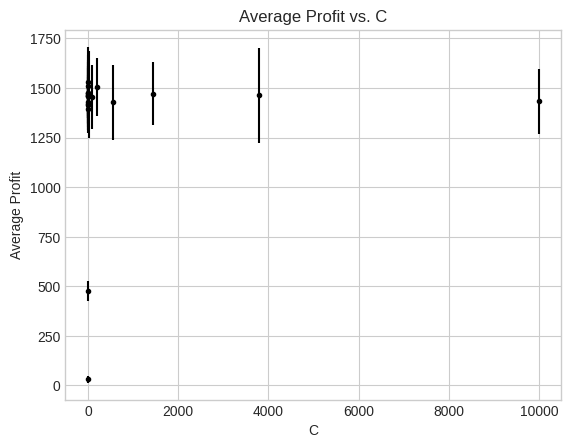

In [340]:
plt.errorbar(C_values, profs_reg, yerr=errs_reg, fmt='.k')
plt.xlabel('C')
plt.ylabel('Average Profit')
plt.title('Average Profit vs. C')
plt.show()

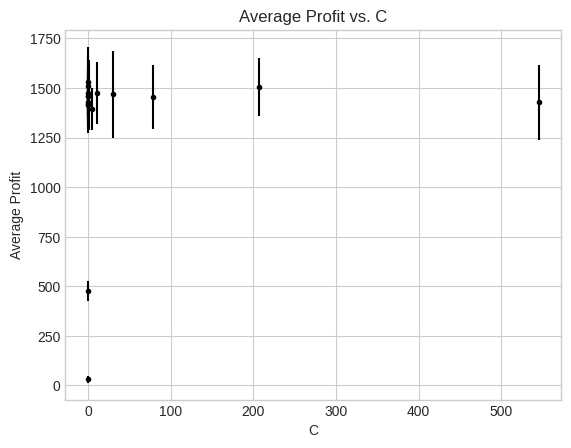

In [341]:
filtered_C_values = [C for C in C_values if C < 600]
filtered_profs_reg = [profs for C, profs in zip(C_values, profs_reg) if C < 600]
filtered_errs_reg = [errs for C, errs in zip(C_values, errs_reg) if C < 600]

plt.errorbar(filtered_C_values, filtered_profs_reg, yerr=filtered_errs_reg, fmt='.k')
plt.xlabel('C')
plt.ylabel('Average Profit')
plt.title('Average Profit vs. C')
plt.show()

Выигрыш получить удалось, прибыль выросла по сравнению с предыдущим пунктом.

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

Коэффициент находится всегда разный (но тут получился самый частый 0.0018329807108324356), но из графиков и из результатов понятно, что плотность разных С тем выше, чем меньше их значения. То есть С удалены друг от друга тем сильнее, чем больше отличаются их начения. Так что и значения мы чаще будем получать меньшие.

In [227]:
for k in range(10):
  C_values = np.logspace(-4, 4, 20)
  best_C = None
  best_average_profit = -np.inf
  for C in C_values:
      model = LogisticRegression(C=C, max_iter=1000)
      model.fit(X_train, y_train)
      profits = []
      for i in range(5):
          y_proba = model.predict_proba(test_dfs[i])[:, 1]
          positive_predictions = y_proba >= 0.5
          true_positives = (positive_predictions & (y_test_dfs[i] == 1)).sum()
          total_calls = positive_predictions.sum()
          total_revenue = np.random.uniform(0, 20, true_positives).sum()
          total_cost = total_calls * 1
          profit = total_revenue - total_cost
          profits.append(profit)
      average_profit = np.mean(profits)
      if average_profit > best_average_profit:
          best_average_profit = average_profit
          best_C = C
  print(f'Лучший С {best_C}')
  print(f'Средняя прибыль {best_average_profit}')

Лучший С 11.288378916846883
Средняя прибыль 1569.0745124064147
Лучший С 1438.44988828766
Средняя прибыль 1597.5669292509533
Лучший С 0.0018329807108324356
Средняя прибыль 1558.2060597567047
Лучший С 0.0018329807108324356
Средняя прибыль 1604.587989366299
Лучший С 10000.0
Средняя прибыль 1563.595459337884
Лучший С 0.0018329807108324356
Средняя прибыль 1571.0227568841203
Лучший С 0.0018329807108324356
Средняя прибыль 1562.812630998304
Лучший С 1438.44988828766
Средняя прибыль 1575.8047719949875
Лучший С 29.763514416313132
Средняя прибыль 1567.8577134265342
Лучший С 0.0006951927961775605
Средняя прибыль 1554.545580454434


#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ Для нашего бизнеса скорее здесь важнее precision. Стоимость каждого звонка - 1$, это много. При этом, если мы угадали, то наша прибыль от одного звонка бдуте в 9 раз больше затрат, а если нет - то мы теряем доллар. Так что если мы хотим минимизировать затраты на клиентов, заонки которым нам будут только в убыток, точность (precision) важнее. Однако recall тоже важен, если мы ставим перед собой другую цель - если нам нужно увеличить охват, кол-во депозитов (например, мы хотим пока просто занять долю рынка, и нам неважно, в убыток это, или нет), то, конечно, нам нужно постараться не упустить ни одного потенциального клиента, так что мы будем максимиировать полноту. Тем не менее сюжет с точностью более реалистичный.


> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

Лучший порог: 0.13
Средняя прибыль при лучшем пороге: 3524.7671140281454


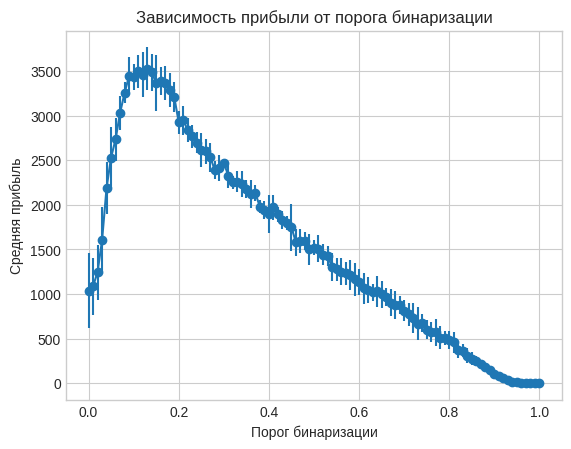

In [146]:
thresholds = np.arange(0, 1.01, 0.01)
best_threshold = None
best_average_profit = -np.inf
profs_thresh = []
errs_thresh = []

model = LogisticRegression(C=4.281332398719396, max_iter=1000)
model.fit(X_train, y_train)

for threshold in thresholds:
    profits = []
    for i in range(5):
        y_proba = model.predict_proba(test_dfs[i])[:, 1]
        positive_predictions = y_proba >= threshold
        true_positives = (positive_predictions & (y_test_dfs[i] == 1)).sum()
        total_calls = positive_predictions.sum()
        total_revenue = np.random.uniform(0, 20, true_positives).sum()
        total_cost = total_calls * 1
        profit = total_revenue - total_cost
        profits.append(profit)

    average_profit = np.mean(profits)
    profs_thresh.append(average_profit)
    errs_thresh.append(statistics.stdev(profits))

    if average_profit > best_average_profit:
        best_average_profit = average_profit
        best_threshold = threshold

print(f'Лучший порог: {best_threshold}')
print(f'Средняя прибыль при лучшем пороге: {best_average_profit}')

plt.errorbar(thresholds, profs_thresh, yerr=errs_thresh, fmt='-o')
plt.xlabel('Порог бинаризации')
plt.ylabel('Средняя прибыль')
plt.title('Зависимость прибыли от порога бинаризации')
plt.grid(True)
plt.show()

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ Как я уже писала, чем ниже порог, тем выше точность, тем выше прибыль. Так что порог будет там, где градиент нашего принака минимален.

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [117]:
from sklearn.metrics import precision_score, recall_score

In [163]:
precisions = []
recalls = []

model = LogisticRegression(C=4.281332398719396, max_iter=1000)
model.fit(X_train, y_train)

for i in range(5):
    y_proba = model.predict_proba(test_dfs[i])[:, 1]
    y_pred = y_proba >= 0.13
    precision = precision_score(np.array(y_test_dfs[i]), y_pred)
    recall = recall_score(y_test_dfs[i], y_pred)
    precisions.append(precision)
    recalls.append(recall)
average_precision = np.mean(precisions)
std_precision = np.std(precisions)
average_recall = np.mean(recalls)
std_recall = np.std(recalls)
print(f'Средняя точность {average_precision}')
print(f'Стандартное отклонение точности {std_precision}')
print(f'Средняя полнота {average_recall}')
print(f'Стандартное отклонение полноты {std_recall}')

Средняя точность 0.34658104759414216
Стандартное отклонение точности 0.011407152132847891
Средняя полнота 0.5407894523861365
Стандартное отклонение полноты 0.012991532005400874


Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [165]:
X_train, X_test, y_train, y_test = train_test_split(transformed_data, y, test_size = 0.25, random_state = 500)

In [166]:
y_pred = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc((recall[recall >= 0.5] - 0.5) / 0.5, precision[recall >= 0.5])
pr_auc

0.20210102713961894

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ Я сначала выпила стакан воды, потом съела зернистый творог с малиновым вареньем (маминым).